In [1]:
import re
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np, pandas as pd
from IPython.display import HTML
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt

## (1) Translating Words from Aligned Parallel Texts

First, we need to fix some spacing and tokenization issues in the text and load the text in.

In [2]:
# import regex
# def correctSpacing(inFile, outFile):
#     with open(inFile, 'r', encoding='utf-8') as fh:
#         raw = fh.read()
#     raw1 = regex.sub(r'(\p{Ll})\.(\p{Lu})', '\g<1>. \g<2>', raw)
#     raw2 = regex.sub(r'(\/\d\d\d\d)(\p{Lu})', '\g<1> \g<2>', raw1)
#     raw3 = regex.sub(r'(\/\d\d)(\p{Lu})', '\g<1> \g<2>', raw2)
#     with open(outFile, 'w', encoding='utf-8') as fh:
#         fh.write(raw3)

# correctSpacing('./data/greek.txt', './data/greek.new.txt')
# correctSpacing('./data/english.txt', './data/english.new.txt')

In [3]:
def getInputList(inFile):
    with open(inFile, 'r', encoding='utf-8') as fh:
        raw = fh.read().split('\n')
    return [x for x in raw if x] # strip empty lines

greeks = getInputList('./data/greek.new.txt')
engs = getInputList('./data/english.new.txt')

################################################################################

__Tranlation of Washington__

From looking at the English file with lines containing "Washington", the Greek translation seems to be "Ουάσιγκτον", which checked to be correct from Google translate.

__Functions to calculate A, B, and C__

First, we need to process the document. We could leverage the `CountVectorizer` of `sklearn` to produce a term-document matrix of binary counts. From these matrices, we could do the calculation we want.

In [4]:
engVec = CountVectorizer(binary=True)
engMat = engVec.fit_transform(engs)
engTerms = engVec.get_feature_names()
engVcb = {k: v for v, k in enumerate(engTerms)}

ellVec = CountVectorizer(binary=True)
ellMat = ellVec.fit_transform(greeks)
ellTerms = ellVec.get_feature_names()
ellVcb = {k: v for v, k in enumerate(ellTerms)}

In the following section, a function is written to get the term vector and another function is written to calculate the PMI and the underlying components. 

In [5]:
def getVec(term, english=True):
    if english:
        return engMat[:, engVcb[term]]
    else: # Greek
        return ellMat[:, ellVcb[term]]

def getPMIinfo(vec1, vec2):
    A = (vec1.transpose() * vec2).sum()
    B = vec1.sum() - A
    C = vec2.sum() - A
    PMI = np.log2(vec1.shape[0]*A / (A+B) / (A+C))
    return A, B, C, PMI

The PMI and the components between "motorcycle", "μοτοσικλέτα" are as follows. Since it has a high PMI, it is likely the translation.

In [6]:
x = getVec('motorcycle', True)
y = getVec('μοτοσικλέτα', False)
print('A=%d, B=%d, C=%d, PMI=%f'%getPMIinfo(x,y))

A=4, B=1, C=0, PMI=11.550747


__Top-5 ranked Greek Candidates__

Since the data is stored term-document matrices, the calculation of the PMI can be done with linear algebra. The following function calculates the components of PMI (only for candidates with intersection of larger than 5), find the candidates with the highest 5 PMI scores, and output a table of them with the corresponding Greek terms.

In [7]:
def getTopGreekTerms(engTerm, N=5, getTable=False):
    vec = engMat[:, engVcb[engTerm]]
    nSentEng = vec.sum()
    nsSentEll = ellMat.sum(axis=0).A1
    
    As = (vec.transpose() * ellMat).todense().A1
    idx = (As > 5).nonzero()[0]
    As = As[idx]
    
    Bs = nSentEng - As
    Cs = nsSentEll[idx] - As
    PMI = np.log2(vec.shape[0]*As / (As+Bs) / (As+Cs))
    
    topN = PMI.argpartition(-N)[-N:]
    topN = topN[PMI[topN].argsort()[::-1]]
    outTerms = [ellTerms[x] for x in idx[topN]]
    
    if getTable:
        data = zip(outTerms,As[topN],Bs[topN],Cs[topN],PMI[topN])
        return pd.DataFrame(data, columns=['Greek Terms','A','B','C','PMI'])
    else:
        return outTerms

In [8]:
tmp = getTopGreekTerms('telephone', getTable=True)
HTML(tmp.to_html(index=False))

Greek Terms,A,B,C,PMI
συνομιλία,17,94,0,7.078259
τηλεφώνου,10,101,0,7.078259
τηλεφωνικής,8,103,1,6.908334
τηλεφωνική,27,84,4,6.878950
συνομιλίας,6,105,2,6.663222


In [9]:
tmp = getTopGreekTerms('swimming', getTable=True)
HTML(tmp.to_html(index=False))

Greek Terms,A,B,C,PMI
κολύμβησης,17,30,0,8.318086
κολύμβηση,13,34,1,8.211171
σκοποβολή,6,41,2,7.903049
μετάλλια,7,40,21,6.318086
αθλητές,9,38,30,6.202609


In [10]:
tmp = getTopGreekTerms('helicopter', getTable=True)
HTML(tmp.to_html(index=False))

Greek Terms,A,B,C,PMI
ελικοπτέρου,7,18,0,9.228819
ελικόπτερο,15,10,0,9.228819
συνετρίβη,6,19,10,7.813781
συντριβή,6,19,13,7.565854
θάλασσα,6,19,160,4.438742


In [11]:
tmp = getTopGreekTerms('washington', getTable=True)
HTML(tmp.to_html(index=False))

Greek Terms,A,B,C,PMI
ουασιγκτον,47,1239,0,3.544000
πεντάγωνο,9,1277,0,3.544000
μπούς,8,1278,0,3.544000
file,31,1255,0,3.544000
ουασινγκτον,213,1073,1,3.537243


__PMI Table for Select Terms__

In order to keep the formatting of this workbook reasonable, the output of this section is in a separate `translation.txt` printout as there are more than 900 lines.

In [12]:
# get all English terms appearing between 70 and 80 lines (inclusive)
idx = np.logical_and(70 <= engMat.sum(axis=0), engMat.sum(axis=0) <= 80).A1
selectTerms = [engTerms[x] for x in idx.nonzero()[0]]

In [13]:
with open('translations.txt', 'w', encoding='utf-8') as fh:
    for t in selectTerms: # loop over selected terms
        fh.write('English term: [%s]\n'%t)
        tmp = getTopGreekTerms(t, getTable=True)
        fh.write(tmp.to_string(index=False)+'\n\n')

##  Neural Machine Translation Tool

For this part, I had difficulties in setting things up on AWS. The set-up script did not work due to PyYAML already being installed. AWS also did not approve of my request to use GPU instances. Instead, I set up an n1-highmem-4 instance on Google Cloud Platform with NVIDIA Tesla P100 GPU, and the request for increased quota was approved without problem. I was able to install all the packages needed and complete the training.

To analyze the training process, we need to first read in the log file.

In [14]:
with open('./data/sockey.log', 'r', encoding='utf-8') as fh:
    raw = fh.read()
    log = [l for l in raw.split('\n') if l] # get all non-empty lines

__Time to complete training__

In [15]:
tmp = re.findall(r'\d+-\d+-\d+:\d+:\d+:\d+', raw)
t1 = datetime.strptime(tmp[0],'%Y-%m-%d:%H:%M:%S')
t2 = datetime.strptime(tmp[-1],'%Y-%m-%d:%H:%M:%S')
print('Training time elapsed: %.1f hours.'%((t2-t1).total_seconds()/3600))

Training time elapsed: 9.4 hours.


__Best validation preplexity__

The relevant info is in the second to last line of the log.

In [16]:
best = re.findall('Best checkpoint: (\d+). ' + 
                  'Best validation perplexity: (\d+\.\d+)', raw)[0]
print('Checkpoint %s had the best validation perplexity at %s.'%best)
################################################################################
tmp = re.findall('Train-perplexity=(\d+\.\d+)', raw)
print('Final training perplexity is: %s.'%tmp[-1])

Checkpoint 80 had the best validation perplexity at 81.440959.
Final training perplexity is: 5.324128.


__BLEU value at different checkpoints__

In [17]:
mt = re.compile(r"Decoder-(\d+).+?'bleu-val': (\d+.\d+(?:[eE]-?\d+)?)")
chkpt,bleus = zip(* [(int(x)+1,float(y)) for x,y in mt.findall(raw)])
print('BLEU at Checkpoint %s is %f.'%(best[0],bleus[int(best[0])-2]))

BLEU at Checkpoint 80 is 0.121539.


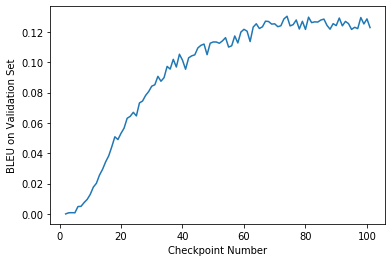

In [18]:
plt.plot(chkpt, bleus)
plt.xlabel('Checkpoint Number')
plt.ylabel('BLEU on Validation Set')
plt.show()

__Translating German sentences__

The translation is: "we believe that illegal cross @-@ border border crossing is a claim ."

__Tracking changes in translation__

For line 241 in the input file, the original German line is "das Telefon selbst führt Sie durch den Rest des Prozesses ." When put into Google Translate, the corresponding English seems to be: "The phone itself will guide you through the rest of the process.". Based on the program, here is how the translation progressed through the checkpoints:

* Checkpoint 1: `the the the the the the the the the the the the the . .`
* Checkpoint 10: `the case of the case of the implementation of the implementation of the process .`
* Checkpoint 20: `in the case of the event of the process of the process .`
* Checkpoint 30: `the name of the telephone will be the rest of the process .`
* Checkpoint 40: `the telephone can be the rest of the process .`
* Checkpoint 50: `the telephone itself will be able by the rest of the process .`
* Checkpoint 60: `the telephone , it will be able by the rest of the process .`
* Checkpoint 70: `the telephone itself will be able to take place by the rest of the process .`
* Checkpoint 80: `the telephone itself will be able by the rest of the process .`
* Checkpoint 90: `the telephone itself will enable the rest of the process .`
* Checkpoint 100: `the telephone itself will be allowed by the rest of the process .`

In terms of performance, around checkpoint 50 is when the translation start to capture the general meaning and becoming syntactical. Prior to checkpoint 50, the results are not really usable. For this specific sentence, the machine translation never quite captured the meaning of "führt", or "lead" in English.

## Evaluating MT Quality with BLEU ##

In addition to the information in the lectures, we also leveraged [this](https://en.wikipedia.org/wiki/BLEU) Wikipedia article. There are three steps in calculating BLEU score:

1. Generate all n-grams, 1 ≤ n ≤ 4
1. Calculate precision for each n-gram level, clipped at the min of the reference set
1. Find geometric mean of the four n-gram levels.

In [19]:
# function to generate all n-grams between two n's
def nGramize(toks, minN=1, maxN=4):
    outGrams = [Counter() for x in range(minN,maxN+1)]
    nToks = len(toks)
    for x in range(nToks):
        for y in range(x+minN, min(nToks,x+maxN)+1):
            outGrams[y-x-1][' '.join(toks[x:y])] += 1
    return outGrams

nGramize(['to','be','or','not','to','be']) # example

[Counter({'to': 2, 'be': 2, 'or': 1, 'not': 1}),
 Counter({'to be': 2, 'be or': 1, 'or not': 1, 'not to': 1}),
 Counter({'to be or': 1, 'be or not': 1, 'or not to': 1, 'not to be': 1}),
 Counter({'to be or not': 1, 'be or not to': 1, 'or not to be': 1})]

In [20]:
toktok = ToktokTokenizer() # use TokTok for simplicity

def calcBLEU(ref, candidate, debug=False):
    refSet = nGramize(toktok.tokenize(ref)) # tokenize and gen all n-grams
    candSet = nGramize(toktok.tokenize(candidate)) # same for candidate
    score = 1
    for n in range(4):
        inter = refSet[n] & candSet[n] # intersection, clipped at min of either
        prec = sum(inter.values()) / sum(candSet[n].values()) # out of all ngrams
        score *= prec**(1/4)
        if debug:
            print('Precision for %d-gram is: %f'%(n+1,prec))
        
    # adjust by preveity penalty
    bleu = min(1, sum(candSet[0].values())/sum(refSet[0].values())) * score
    if debug:
        print('Overall BLEU is: %f'%bleu)
    return bleu

__N-gram precisions and BLEU score__

Scores for both system are reported below.

In [21]:
ref = 'we are very clear on this : illegal border crossing is a crime .'
sysA = 'we say it very clearly : illegal border crossing is a crime .'
sysB = 'we want is important : illegal border concerns is a crime .'


print('== BLEU for System A ==')
calcBLEU(ref, sysA, True);

print('\n== BLEU for System B ==')
calcBLEU(ref, sysB, True);

== BLEU for System A ==
Precision for 1-gram is: 0.769231
Precision for 2-gram is: 0.583333
Precision for 3-gram is: 0.545455
Precision for 4-gram is: 0.500000
Overall BLEU is: 0.549213

== BLEU for System B ==
Precision for 1-gram is: 0.666667
Precision for 2-gram is: 0.454545
Precision for 3-gram is: 0.300000
Precision for 4-gram is: 0.111111
Overall BLEU is: 0.271734


__BLEU metrics imperfection__

BLEU metrics compares a candidate trnaslation with a reference one. Therefore, the metric is only as good as the reference. For a given sentence, there can be many different ways of writing a translation, depending on word choices and writing style. If a translation uses unconventional word choice, it could be scored not as well. For example, in Indian English, the expression "do the needful" is common, but it is considered archaic in American English.

Secondly, BLEU ignores word meaning. Some translations may be preferred by a human if it captures the general meaning of the original sentence even if it does not read fluently. For example, consider the following translations:

In [22]:
ref = 'I read through the instructions.'
sys1 = 'I parsed through the instructional manual.'
sys2 = 'I ripped up the instructions.'

print('== BLEU for 1st Sentence ==')
calcBLEU(ref, sys1, True);

print('\n== BLEU for 2nd Sentence==')
calcBLEU(ref, sys2, True);

== BLEU for 1st Sentence ==
Precision for 1-gram is: 0.571429
Precision for 2-gram is: 0.166667
Precision for 3-gram is: 0.000000
Precision for 4-gram is: 0.000000
Overall BLEU is: 0.000000

== BLEU for 2nd Sentence==
Precision for 1-gram is: 0.666667
Precision for 2-gram is: 0.400000
Precision for 3-gram is: 0.250000
Precision for 4-gram is: 0.000000
Overall BLEU is: 0.000000


The BLEU score of the second sentence is higher, even though it is opposite in meaning of the original sentence.